In [1]:
from multiprocessing import Process, Queue
import firebase_admin
from firebase_admin import credentials, firestore as _firestore, storage as _storage
import numpy as np
from contextlib import suppress
from urllib.request import urlopen

import cv2
import sys
import numpy as np
import datetime
import os
import glob
import mxnet as mx
from mxnet import gluon
from skimage import transform as trans
from easydict import EasyDict as edict
from matplotlib import pyplot as plt
import warnings

from retinaface import RetinaFace

In [2]:
cred = credentials.Certificate("mypic-92b94-firebase-adminsdk-4r0hy-29da90a52f.json")
app = firebase_admin.initialize_app(cred)

In [3]:
firestore = _firestore.client()
storage = _storage.bucket('mypic-92b94.appspot.com')

In [4]:
TOUR_COLLECTION_NAME = 'Tour'
USER_COLLECTION_NAME = 'User'

In [5]:
detector_gpuid = 0
embedder_gpuid = 1

In [6]:
detector = RetinaFace('./model/R50', 0, detector_gpuid, 'net3')

ctx = mx.gpu(embedder_gpuid)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    embedder = gluon.nn.SymbolBlock.imports("./model/model-r100-ii/model-symbol.json", ['data'], "./model/model-r100-ii/model-0000.params", ctx=ctx)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
means [0. 0. 0.]
use_landmarks True
cascade 0
sym size: 9


# Face Detection & Embedding Part

In [7]:
# Todo: make batch version? Maybe it's hard because image sizes can vary?
def detect_faces(detector, image, scales=[1024, 1980], thresh=0.8, flip=False):
    # Validate image array
    assert type(image) is np.ndarray
    assert len(image.shape) == 3  #  W x H x BGR
    assert image.shape[2] == 3  # BGR
    
    im_shape = image.shape
    target_size = scales[0]
    max_size = scales[1]
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])
    #im_scale = 1.0   # Use This if you don't want to scale the original image

    # if im_size_min>target_size or im_size_max>max_size:
    im_scale = float(target_size) / float(im_size_min)
    # prevent bigger axis from being more than max_size:
    if np.round(im_scale * im_size_max) > max_size:
        im_scale = float(max_size) / float(im_size_max)
        
    im_scales = [im_scale]
    
    boxes, landmarks = detector.detect(image, thresh, scales=im_scales, do_flip=flip)
    
    return boxes, landmarks

In [8]:
def resize_and_align_face(image, box, landmark):
    if not hasattr(resize_and_align_face, "_align_src"):
        resize_and_align_face._align_src = np.array([
                [38.2946, 51.6963],
                [73.5318, 51.5014],
                [56.0252, 71.7366],
                [41.5493, 92.3655],
                [70.7299, 92.2041]], dtype=np.float32)
        
    
    box = box.astype(np.int)
    resized_face = cv2.resize(image[box[1]:box[3], box[0]:box[2]], (112, 112))
    
    box_width = box[2] - box[0]
    box_height = box[3] - box[1]
    
    align_dst = landmark
    align_dst[:, 0] -= box[0]
    align_dst[:, 1] -= box[1]
    
    align_dst[:, 0] = align_dst[:, 0] / (box_width / 112.0)
    align_dst[:, 1] = align_dst[:, 1] / (box_height / 112.0)
    
    tform = trans.SimilarityTransform()
    tform.estimate(align_dst, resize_and_align_face._align_src)
    M = tform.params[0:2,:]
    
    aligned_face = cv2.warpAffine(resized_face, M, (112, 112), borderValue = 0.0)
    
    return aligned_face

In [9]:
def embed_face(embedder, ctx, images, batch_size=64):
    for image in images:
        assert image.shape == (112, 112, 3)
    
    batched_images = []
    for idx in range(0, len(images), batch_size):
        batched_images.append(images[idx:idx + batch_size])
    
    embeddings = []
    for batch in batched_images:
        if not batch:
            continue
        input_array = mx.nd.array(batch, ctx=ctx).transpose((0, 3, 1, 2))
        embeddings += list(embedder.forward(input_array).asnumpy())
    
    return embeddings

In [10]:
def box_to_str(box):
    return f"x{box[1]},{box[3]}_y{box[0]},{box[2]}"

# Firebase part

In [11]:
def parse_storage_uri(uri):
    try:
        _, x = uri.split('/o')
        path, y = x.split('?')
        _, token = y.split('token=')
    except:
        # TODO: add exception handling
        path, token = '', ''
    return path.replace('%2F', '/'), token

In [12]:
def calc_embedding_of_image(img):
    print(img.shape)
    plt.imshow(img[..., ::-1])
    plt.show()
    
    try:
        boxes, landmarks = detect_faces(detector, img)
    except:
        return dict()
    
    print(len(boxes))
    aligned_faces = []
    for box, landmark in zip(boxes, landmarks):
        aligned_faces.append(resize_and_align_face(img, box, landmark))

    embeddings = embed_face(embedder, ctx, aligned_faces)
    print(len(embeddings))
    
    document = edict()
    for box, embedding in zip(boxes, embeddings):
        document[box_to_str(box.astype(np.int))] = embedding.tolist()

    return document

In [13]:
def get_blob_from_file_name(document_ref, file_name):
    try:
        doc_path = document_ref.path.split('/')
        file_path = ''
        
        if 'Tour' in doc_path[0]:
            file_path += 'tour_images'
        elif 'User' in doc_path[0]:
            file_path += 'user_images'

        file_path += f'/{doc_path[1]}/{file_name}'
        
        blob = storage.blob(file_path)
        
        return blob
    except:
        #print('There is no file at', file_path)
        # or raise specific error
        return False

In [14]:
def download_image_from_file_name(document_ref, file_name):
    blob = get_blob_from_file_name(document_ref, file_name)
    try:
        img = cv2.imdecode(np.frombuffer(blob.download_as_string(), np.uint8), cv2.IMREAD_COLOR)
    except:
        img = None
        
    return img

In [15]:
def download_image_from_uri(uri):
    return cv2.imdecode(np.frombuffer(urlopen(uri).read(), np.uint8), cv2.IMREAD_COLOR)

In [16]:
def check_unembedded_images(change):
    embedded = dict()
    deleted = list()
    
    images = change.document.get('images')
    
    for img_uri in images  if (images is not None) else list():
        path, token = parse_storage_uri(img_uri)
        file_name = path.split('/')[-1]
        embedded[file_name] = False
        
    
    for embedding_doc in change.document.reference.collection('Embedding').list_documents():
        if embedding_doc.id in embedded:
            embedded[embedding_doc.id] = True
        else:
            deleted.append(embedding_doc.id)
    
    return embedded, deleted

In [17]:
def do_calculation_for_unembedded_images(change, embedded):
    # Calculate embedding for not embedded image
    for file_name, processed in embedded.items():
        if not processed:
            image = download_image_from_file_name(change.document.reference, file_name)
            if image is not None:
                embeddings = calc_embedding_of_image(image)
                # Write result to database
                try:
                    change.document.reference.collection('Embedding').document(file_name).set(embeddings)
                    embedded[file_name] = True
                except:
                    pass
    return embedded

In [18]:
def handle_embedding_stuff(change):
    embedded, deleted = check_unembedded_images(change)
    #print(embedded)
    for image_file_name in deleted:
        break  # TODO: handle deleted image
        #print('img deleted,', deleted)
        #do_cleanup_for_deleted_tour_image(change, image_file_name)
    
    if not embedded:
        #print('No images here')
        return
    
    after_embedded = do_calculation_for_unembedded_images(change, embedded)
    #print(after_embedded)

In [19]:
def on_tour_snapshot(collection_snapshot, changes, read_time):
    #print('on_tour_snapshot')
    for change in changes:
        doc_ref = change.document.reference
        
        if change.type.name == 'ADDED':
            handle_embedding_stuff(change)
            
        elif change.type.name == 'MODIFIED':
            handle_embedding_stuff(change)
            
        elif change.type.name == 'REMOVED':
            # Delete Embeddings subcollection
            for embedding_doc_ref in  change.document.reference.collection('Embedding').list_documents():
                embedding_doc_ref.delete()
            
            #print('Removed tour: {}'.format(change.document.id))

In [20]:
def on_user_snapshot(collection_snapshot, changes, read_time):
    #print('on_user_snapshot')
    for change in changes:
        #print(f"Change: {change.document.reference}")
        if change.type.name == 'ADDED':
            handle_user_embedding_stuff(change)
        elif change.type.name == 'MODIFIED':
            handle_user_embedding_stuff(change)
        elif change.type.name == 'REMOVED':
            for tour_doc in firestore.collection(TOUR_COLLECTION_NAME).where('participants', 'array_contains', change.document.reference).stream():
                participants = tour_doc.get('participants')
                
                with suppress(ValueError, AttributeError):
                    participants.remove(image_file_name)
                    tour_doc.reference.update({'participants': participants})

In [21]:
def handle_user_embedding_stuff(change):
    #print("handle_user_embedding_stuff called!")
    try:
        uris = change.document.get('uris')
        #print(uris)
    except:
        return
    
    try:
        embeddings = change.document.get('embeddings')
    except:
        embeddings = dict()
    
    
    for uri in uris:
        path, token = parse_storage_uri(uri)
        file_name = path.split('/')[-1]
        
        if file_name not in embeddings:
            image = download_image_from_uri(uri)
            #print(image.shape)
            
            image_embeddings = calc_embedding_of_image(image)
            #print("Embeddings calculated")
            
            if len(image_embeddings) == 1:
                #print("Face Found")
                for _, value in image_embeddings.items():
                    embeddings[file_name] = value
            else:
                #print("Face Not Found")
                embeddings[file_name] = False
                
            #print(image.shape)
            
    #print(embeddings.keys())
    
    change.document.reference.update({'embeddings': embeddings})

In [22]:
tour_watcher = firestore.collection(TOUR_COLLECTION_NAME).on_snapshot(on_tour_snapshot)
user_watcher = firestore.collection(USER_COLLECTION_NAME).on_snapshot(on_user_snapshot)

I'm currently in 125th iteration, and listeners have died for 0 times(3456, 4608, 3)


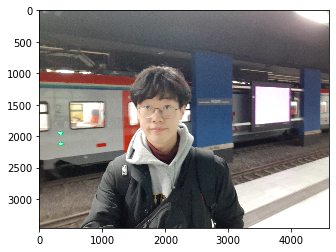

I'm currently in 127th iteration, and listeners have died for 0 times1
1
I'm currently in 152th iteration, and listeners have died for 0 times(3456, 4608, 3)
I'm currently in 153th iteration, and listeners have died for 0 times

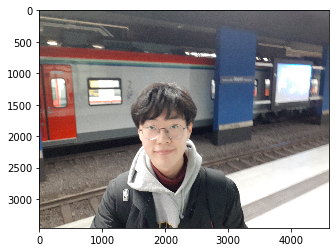

1
1
(3456, 4608, 3)


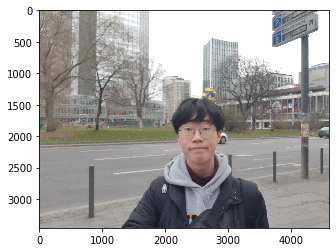

1
1
I'm currently in 169th iteration, and listeners have died for 0 times(3456, 4608, 3)
I'm currently in 170th iteration, and listeners have died for 0 times

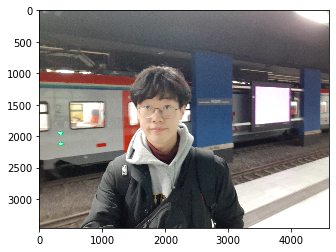

1
1
(3456, 4608, 3)


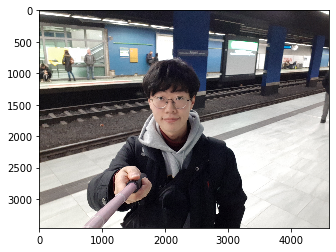

2
2
I'm currently in 171th iteration, and listeners have died for 0 times(3456, 4608, 3)


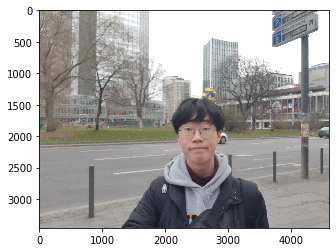

1
1
I'm currently in 197th iteration, and listeners have died for 0 times(3456, 4608, 3)


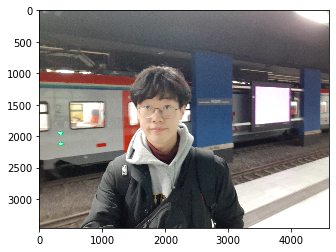

1
1
(3456, 4608, 3)
I'm currently in 198th iteration, and listeners have died for 0 times

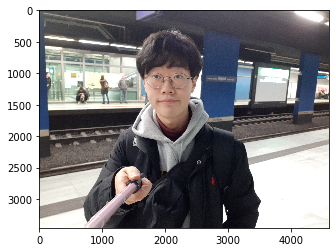

2
2
(3456, 4608, 3)


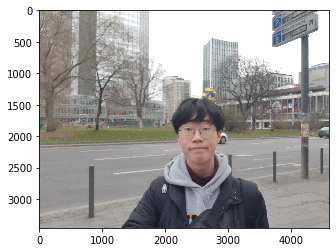

1
1
I'm currently in 210th iteration, and listeners have died for 0 times(3456, 4608, 3)


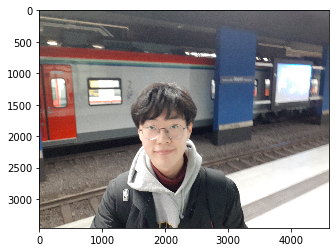

1
1
I'm currently in 276th iteration, and listeners have died for 0 times(3456, 4608, 3)
I'm currently in 277th iteration, and listeners have died for 0 times

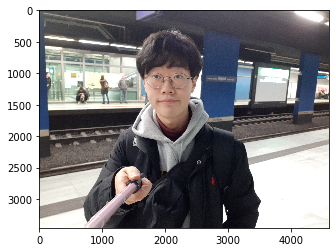

2
2
I'm currently in 448th iteration, and listeners have died for 0 times(2448, 3264, 3)


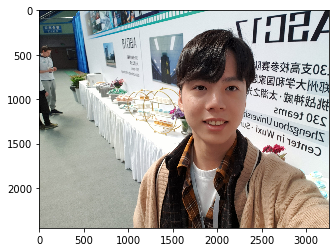

2
2
I'm currently in 473th iteration, and listeners have died for 0 times(2448, 3264, 3)
I'm currently in 474th iteration, and listeners have died for 0 times

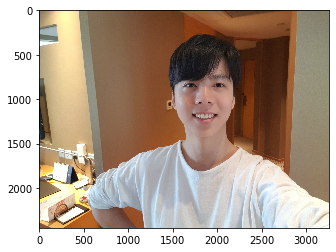

1
1
I'm currently in 518th iteration, and listeners have died for 0 times(2448, 3264, 3)


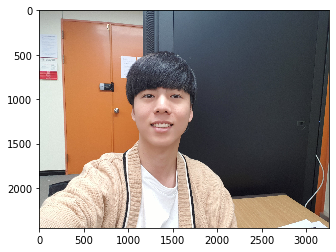

1
1
I'm currently in 605th iteration, and listeners have died for 0 times

In [ ]:
from time import sleep
i = 0
deaths = 0
while True:
    i += 1
    print(f"\rI'm currently in {i}th iteration, and listeners have died for {deaths} times", end="", flush=True)
    if not tour_watcher.is_active:
        deaths += 1
        tour_watcher.close()
        tour_watcher = firestore.collection(TOUR_COLLECTION_NAME).on_snapshot(on_tour_snapshot)
    if not user_watcher.is_active:
        deaths += 1
        user_watcher.close()
        user_watcher = firestore.collection(USER_COLLECTION_NAME).on_snapshot(on_user_snapshot)
    
    sleep(5)

In [ ]:
#user_watcher.close()

In [ ]:
#tour_watcher.close()